<a href="https://colab.research.google.com/github/Svetorus/Pytorch/blob/main/pytorch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image, make_grid

from IPython.display import clear_output

%matplotlib inline

## Домашнее задание: 

**1). Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:**
 - **Сгенерировать настоящие данные**
 - **Изменить архитектуру дискриминатора и генератора**
 - **Без графиков домашку не принимаю**

In [ ]:
def func_y(x):
    if x == 0:
        return 1
    return np.sin(x)/x - x/10
    
func_y = np.vectorize(func_y)

In [ ]:
lr = 0.001
n_epochs = 2010
batch_size = 32
seed = 2020

In [ ]:
torch.manual_seed(seed)

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.randint(-15, 15, (train_data_length, ))
train_data[:, 1] = torch.FloatTensor(func_y(train_data[:, 0]))
#train_labels = torch.zeros(train_data_length)
train_set = [train_data[i] for i in range(train_data_length)]
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [ ]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            CustomLinearLayer(256, 128),
            nn.ReLU(),            
            nn.Dropout(0.3),
            CustomLinearLayer(128, 64),
            nn.ReLU(),            
            nn.Dropout(0.3),
            CustomLinearLayer(64, 1),
            nn.Sigmoid(),
        )
  
    def forward(self, inputs):
        validity = self.model(inputs)
        return validity


discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(2, 16),
            *block(16, 32),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        output = self.model(x)
        return output


generator = Generator()

In [ ]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
adversarial_loss = nn.BCELoss()

[Epoch: 2000] D loss: 0.5930 G loss: 1.1844


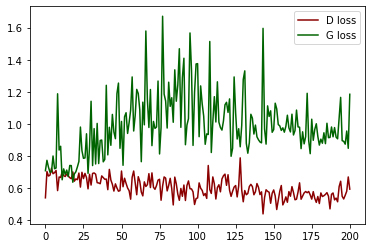

In [ ]:
torch.manual_seed(seed)

d_loss_history, g_loss_history = [], []
xs, ys = [], []
for epoch in range(n_epochs):
    for n, real_data in enumerate(train_loader, 1):
        # Данные для обучения дискриминатора
        valid = torch.ones((batch_size, 1))
        fake = torch.zeros((batch_size, 1))

        z = torch.randn((batch_size, 2))
        gen_data = generator(z)

        all_data = torch.cat((real_data, gen_data))
        all_labels = torch.cat((valid, fake))

        # Обучение дискриминатора
        discriminator.zero_grad()
        all_pred = discriminator(all_data)
        d_loss = adversarial_loss(all_pred, all_labels)
        d_loss.backward()
        optimizer_D.step()

        # Данные для обучения генератора
        z = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        gen_data = generator(z)
        validity = discriminator(gen_data)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size:

            clear_output(wait=True)
            print(f"[Epoch: {epoch}] D loss: {d_loss:.4f} G loss: {g_loss:.4f}")

            gen_data = gen_data.detach()
            xs.append(gen_data[:, 0].tolist())
            ys.append(gen_data[:, 1].tolist())

            d_loss_history.append(d_loss.item())
            g_loss_history.append(g_loss.item())
            plt.plot(d_loss_history, label='D loss', c='darkred')
            plt.plot(g_loss_history, label='G loss', c='darkgreen')
            plt.legend(loc='upper right')
            plt.show()      


Сгенерированные данные - все батчи и самый последний:

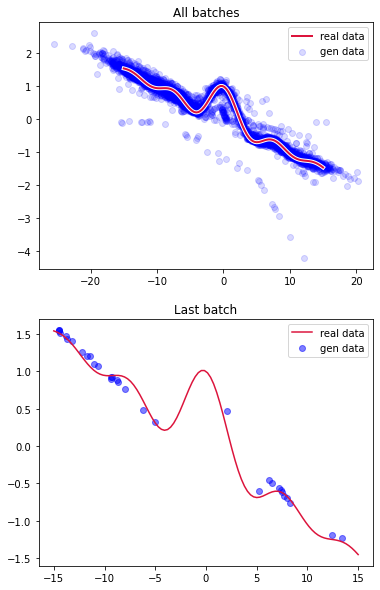

In [ ]:
x = np.linspace(-15, 15, 100)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
axes[0].plot(x, func_y(x), c='w', lw=4)
axes[0].plot(x, func_y(x), c='crimson', label='real data', lw=2)
axes[0].scatter(xs, ys, c='b', alpha=0.15, label='gen data')
axes[0].set_title('All batches')
axes[0].legend(loc='best')

axes[1].plot(x, func_y(x), c='crimson', label='real data')
axes[1].scatter(xs[-1], ys[-1], c='b', alpha=0.5, label='gen data')
axes[1].set_title('Last batch')
axes[1].legend(loc='best')

plt.show()

**2). Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.**

In [ ]:
use_cuda = torch.cuda.is_available()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
n_epochs = 200
batch_size = 64
lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 100

n_classes = 10
img_size = 28
channels = 1

sample_interval = 100

img_shape = (channels, img_size, img_size)
seed = 2020

Данные для обучения:

In [ ]:
torch.manual_seed(seed)

real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

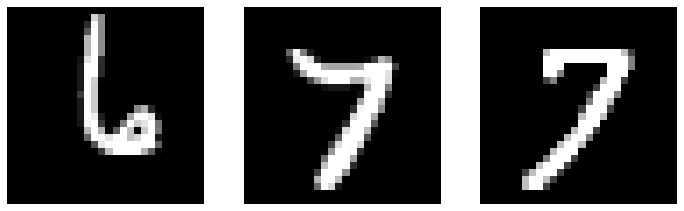

In [ ]:
torch.manual_seed(seed)

dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    img = np.squeeze(images[i])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

Генератор:

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = nn.ModuleDict(
            [['lrelu', nn.LeakyReLU(0.2, inplace=True)],
             ['tanh', nn.Tanh()]]
             )
        
        def block(in_feat, out_feat, kernel_size, stride, padding, normalize=True, activation='lrelu'):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, kernel_size, stride, padding, bias=False)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(self.activations[activation])
            return layers

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7, 0.8),
            self.activations['lrelu']
            )
        
        self.conv = nn.Sequential(
            *block(256, 128, 5, stride=(1, 1), padding=2),
            *block(128, 64, 4, stride=(2, 2), padding=1),
            *block(64, 1, 4, stride=(2, 2), padding=1, normalize=False, activation='tanh'),

    def forward(self, z):
        img = self.fc(z)
        img = img.view(img.size(0), 256, 7, 7)
        img = self.conv(img)
        img = img.view(img.size(0), *img_shape)
        return img

generator = Generator().to(device)

Проверка генератора (результат - картинки 28 х 28):

In [ ]:
torch.manual_seed(seed)

z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)
z.shape

torch.Size([64, 100])

In [ ]:
gen_imgs = generator(z)
gen_imgs.shape

torch.Size([64, 1, 28, 28])

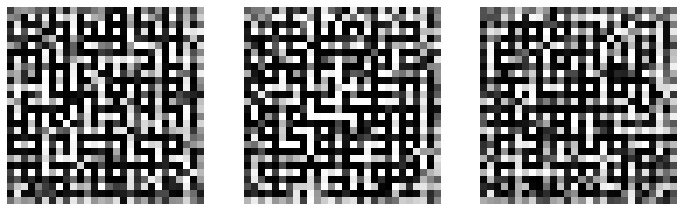

In [ ]:
imgs_numpy = gen_imgs.detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    img = np.squeeze(imgs_numpy[i])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

Дискриминатор (результат - вектор batch_size x 1):

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(),            
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(14*14*128, 1),
            nn.Sigmoid(),
        )
  
    def forward(self, inputs):
        conv_output = self.conv(inputs)      
        conv_output = conv_output.view(batch_size, 14*14*128)  
        validity = self.fc(conv_output)
        return validity


discriminator = Discriminator().to(device)

In [ ]:
validity = discriminator(gen_imgs)
validity.shape

torch.Size([64, 1])

In [ ]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, ax, save_img = True):
    npimg = make_grid(static_sample.data[:batch_size]).cpu().numpy()
    npimg = (npimg * 255).astype(np.uint8)
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    ax.axis('off')
    if save_img:
        save_image(gen_imgs.data[:batch_size], "images/%d.png" % batches_done, nrow=8, normalize=True)

In [ ]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
adversarial_loss = nn.BCELoss()

Обучение DCGAN:

[Epoch 199/200] [Batch 838/938] D loss: 0.2251 G loss: 2.7085


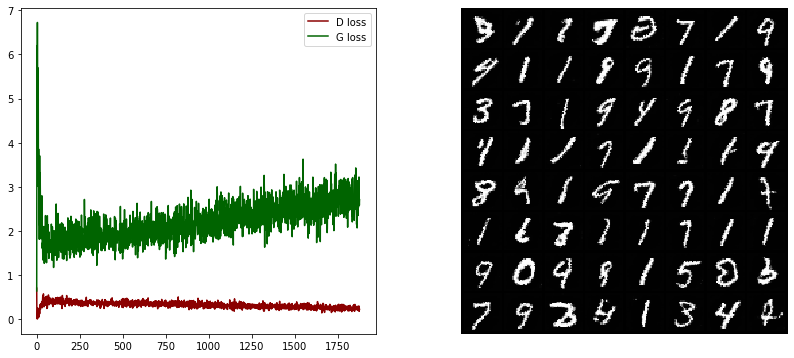

In [ ]:
torch.manual_seed(seed)

d_loss_history, g_loss_history = [], []
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):

        batch_size = imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            clear_output(wait=True)
            print("[Epoch %3d/%3d] [Batch %3d/%3d] D loss: %.4f G loss: %.4f" % \
                  (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 
            
            d_loss_history.append(d_loss.item())
            g_loss_history.append(g_loss.item())     
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            axes[0].plot(d_loss_history, label='D loss', c='darkred')
            axes[0].plot(g_loss_history, label='G loss', c='darkgreen')
            axes[0].legend(loc='upper right')

            sample_image(gen_imgs, axes[1])   

            plt.show()

## GIF с результатами обучения

In [ ]:
import imageio
import re
from glob import glob
from IPython.display import display, Image

Представим обучение в геометрической прогрессии:

In [ ]:
filenames = glob('images/*.png')
filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
filenames = np.array(filenames)

filenames_idx = np.geomspace(1, len(filenames), num=50)
filenames_idx = filenames_idx.astype(np.uint32) - 1
filenames_idx = np.unique(filenames_idx)
filenames = filenames[filenames_idx]

In [ ]:
with imageio.get_writer('myimage.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

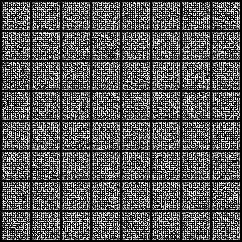

In [ ]:
with open('myimage.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))